In [5]:

# Importar librerías necesarias
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import datetime

import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
root = os.path.join(os.getcwd())
root_data = os.path.join(os.getcwd(), "data")

In [14]:
!git clone https://github.com/Danield0160/dataset_resize.git ./data

Cloning into './data'...
remote: Enumerating objects: 3081, done.
remote: Total 3081 (delta 0), reused 0 (delta 0), pack-reused 3081 (from 1)
Receiving objects: 100% (3081/3081), 150.60 MiB | 17.14 MiB/s, done.
Updating files: 100% (3130/3130), done.


In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Configura TensorFlow para que solo utilice la primera GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("GPU configurada y en uso.")
    except RuntimeError as e:
        print(e)

GPU configurada y en uso.


2024-11-13 13:33:43.955840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13 13:33:43.965356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13 13:33:43.965596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [8]:

# Configuración de TensorBoard
log_dir = os.path.join(root_data,"logs/fit/") + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [9]:

# Cargar el modelo InceptionResNetV2 con pesos preentrenados en ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

# Congelar todas las capas del modelo base para preservar el aprendizaje de ImageNet
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas de clasificación para las categorías "árbol", "río", y "roca"
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Capa de pooling global
x = Dense(1024, activation='relu')(x)  # Capa densa para características adicionales
predictions = Dense(3, activation='softmax')(x)  # Capa de salida con 3 clases

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


2024-11-13 13:33:45.859395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13 13:33:45.859805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13 13:33:45.860059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13 13:33:46.584833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13 13:33:46.585181: I tensorflow/compile

In [ ]:
# Preparación de los datos con ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,  # Rotación aleatoria en un rango de hasta 30 grados
)

# Cambia 'path/to/dataset' al directorio que contiene las carpetas 'arbol', 'rio' y 'roca'
train_generator = train_datagen.flow_from_directory(
    os.path.join(root_data, 'train/'),  # Directorio de datos de entrenamiento
    batch_size=32,
    class_mode='categorical',
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(root_data, 'validation/'),  # Directorio de datos de validación
    batch_size=32,
    class_mode='categorical',
)


Found 2795 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


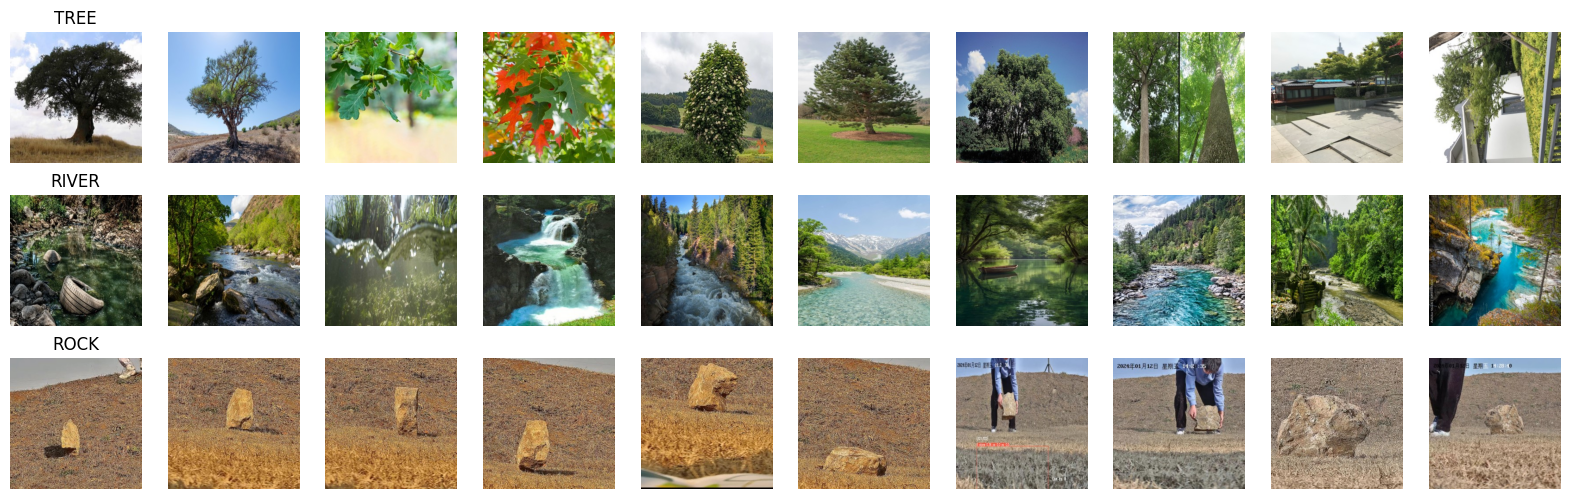

In [ ]:
# Configurar el generador de datos para mostrar ejemplos de imágenes
data_path = os.path.join(root_data, 'train/')
categories = ['tree', 'river', 'rock']

fig, axes = plt.subplots(3, 10, figsize=(20, 6))
for i, category in enumerate(categories):
    folder_path = os.path.join(data_path, category)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)[:10]]
    for j, img_path in enumerate(images):
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(category.upper())
plt.show()

In [12]:

# Entrenamiento del modelo con TensorBoard
history = model.fit(
    train_generator,
    steps_per_epoch=32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,  # Ajusta el número de épocas
    callbacks=[tensorboard_callback]  # Añadir el callback de TensorBoard
)


Epoch 1/20


2024-11-13 13:34:11.237006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-11-13 13:34:12.133115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-13 13:34:14.036547: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5938157ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-13 13:34:14.036592: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-13 13:34:14.041100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 13:34:14.134915: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

32/32 [==============================] - 35s 787ms/step - loss: 0.5940 - accuracy: 0.8365 - val_loss: 0.2776 - val_accuracy: 0.9271
Epoch 2/20
32/32 [==============================] - 22s 686ms/step - loss: 0.1419 - accuracy: 0.9541 - val_loss: 0.1434 - val_accuracy: 0.9375
Epoch 3/20
32/32 [==============================] - 21s 670ms/step - loss: 0.1190 - accuracy: 0.9601 - val_loss: 0.0982 - val_accuracy: 0.9375
Epoch 4/20
32/32 [==============================] - 23s 708ms/step - loss: 0.1131 - accuracy: 0.9639 - val_loss: 0.1426 - val_accuracy: 0.9583
Epoch 5/20
32/32 [==============================] - 26s 794ms/step - loss: 0.0905 - accuracy: 0.9671 - val_loss: 0.0502 - val_accuracy: 0.9792
Epoch 6/20
32/32 [==============================] - 24s 751ms/step - loss: 0.1108 - accuracy: 0.9639 - val_loss: 0.0871 - val_accuracy: 0.9792
Epoch 7/20
32/32 [==============================] - 24s 740ms/step - loss: 0.0714 - accuracy: 0.9791 - val_loss: 0.1359 - val_accuracy: 0.9167
Epoch 8/20

Para terminar el proceso antiguo del tensorboard en caso de que se haya quedado activo y no deje crear uno

In [1]:
import psutil

# Cambia el puerto al que deseas verificar
puerto = 6006  # Ejemplo para el puerto 6006

# Encontrar el proceso que está utilizando el puerto
def encontrar_proceso_por_puerto(puerto):
    for conexion in psutil.net_connections():
        if conexion.laddr.port == puerto:
            pid = conexion.pid
            proceso = psutil.Process(pid)
            return proceso
    return None

proceso = encontrar_proceso_por_puerto(puerto)

if proceso:
    print(f"El puerto {puerto} está siendo utilizado por el proceso: {proceso.name()} (PID: {proceso.pid})")
else:
    print(f"No se encontró ningún proceso utilizando el puerto {puerto}")
    
if proceso:
    proceso.terminate()  # Termina el proceso de manera segura
    print(f"Proceso {proceso.name()} (PID: {proceso.pid}) finalizado.")
else:
    print(f"No se encontró ningún proceso utilizando el puerto {puerto}")

In [20]:
%load_ext tensorboard

In [56]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

In [22]:
%tensorboard --logdir data/logs/fit/

Reusing TensorBoard on port 6006 (pid 263), started 0:00:03 ago. (Use '!kill 263' to kill it.)

In [17]:
# Guardar el modelo entrenado
model.save(os.path.join(root_data, "modelo_inceptionresnetv2_arbol_rio_roca.h5"))


Para iniciar TensorBoard, ejecuta este comando en una celda en Google Colab o en una terminal local:

```python
# Para Google Colab
%tensorboard --logdir logs/fit
```

```bash
# Para entorno local
tensorboard --logdir logs/fit
```


Para el gradio hace falta resetear el kernel

In [ ]:
%pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 38.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 45.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 26.4 MB/s eta 0:00:00
     ━━━━

In [19]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Cargar el modelo desde el archivo .h5
modelo = tf.keras.models.load_model(os.path.join(root_data, "modelo_inceptionresnetv2_arbol_rio_roca.h5"))

# Definir las clases según tu modelo
clases = ['río', 'roca', 'árbol']  # Asegúrate de que las clases coincidan con tu modelo

# Tamaño esperado de entrada por el modelo (ajústalo si es necesario)
tamano_imagen = (224, 224)  # Cambia esto si tu modelo espera un tamaño diferente

# Función de predicción
def predecir_imagen(img):
    # Redimensionar la imagen al tamaño que espera el modelo
    img = img.resize(tamano_imagen)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión extra para el lote
    img_array /= 255.0  # Normalizar los valores entre 0 y 1 si es necesario

    # Realizar la predicción
    prediccion = modelo.predict(img_array)[0]  # Obtener las probabilidades para cada clase
    predicciones_porcentajes = [(clase, probabilidad * 100) for clase, probabilidad in zip(clases, prediccion)]
    
    # Ordenar las predicciones de mayor a menor
    predicciones_ordenadas = sorted(predicciones_porcentajes, key=lambda x: x[1], reverse=True)
    
    # Formatear el resultado
    resultado = "\n".join([f"{clase}: {porcentaje:.2f}%" for clase, porcentaje in predicciones_ordenadas])
    return resultado

# Crear la interfaz de Gradio
interfaz = gr.Interface(
    fn=predecir_imagen,                # Función de predicción
    inputs=gr.Image(type="pil"),        # Entrada de imagen
    outputs=gr.Textbox(),               # Salida de texto
    title="Clasificador de Árbol, Roca y Río",   # Título de la interfaz
    description="Sube una imagen para ver la clasificación en términos de 'árbol', 'roca' o 'río', ordenada por confianza."  # Descripción
)

# Lanzar la interfaz
interfaz.launch(share=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://d11f7b763e7b0d6d29.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 31ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.8/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 1931, in process_api
    inputs = await self.preprocess_data(
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 1662, in preprocess_data
    processed_input.append(block.preprocess(inputs_cached))
  File "/usr/local/lib/python3.8/dist-packages/gradio/components/image.py", line 190, in preprocess
    im = PIL.Image.open(file_path)
  File "/usr/local/lib/python3.8/dist-packages/PIL/Image.py", line 3280, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file '/tmp/gradio/0c1169a1cdbcbaf12af834c597f038ee85246e987715a88e8175d6fbd

1/1 [==============================] - 0s 31ms/step
